In [ ]:
# import pdb; pdb.set_trace()
# import pudb; pudb.set_trace()

# df.style.background_gradient(
#     cmap='coolwarm', 
#     axis=None, 
#     vmin=-1, 
#     vmax=1
# )  # 'Blues', 'coolwarm', 'RdBu_r' & 'BrBG'

# pd.set_option('precision', 2)

# .plot_bokeh(sizing_mode="scale_height")
# .plot_bokeh(kind='hist', bins=1000, sizing_mode="scale_height", xlim=[0, .1])

# Imports

In [5]:
%load_ext autoreload
%autoreload 2

import pandas as pd
pd.set_option('float_format', '{:f}'.format)
pd.set_option('display.max_rows', 40)
pd.set_option('display.max_columns', 99)

import matplotlib as mpl
from matplotlib import style
style.use('fivethirtyeight')
mpl.rcParams['figure.figsize'] = [20, 7]

In [12]:
import datetime as dt
import pickle
import numpy as np
import pandas as pd
import pandas_bokeh
pandas_bokeh.output_file("/tmp/bokeh_output.html")
import ray

from data_layer import arrow_dataset, storage_adaptor
from tick_filter import streaming_tick_filter
from tick_sampler import streaming_tick_sampler, daily_stats
from workflows import sampler_task, sampler_flow
from utilities import date_fu, project_globals as g
from data_layer import storage_adaptor, fsspec_factory, data_access


config = {
    'meta': {
        'symbol': 'SAND',
        'start_date': '2019-01-01',
        'end_date': '2019-03-01',
        'config_id': 'renko_v1',
        'presist_destination': 'remote',
    },
    'filter': {
        'mad_value_winlen': 22,
        'mad_deviation_winlen': 1111,
        'mad_k': 17,
        'jma_winlen': 7,
        'jma_power': 2,
    },
    'sampler': {
        'renko_return': 'price_jma_return',
        'renko_size': 0.1,  # for simple runs
        'renko_reveral_multiple': 2,
        'renko_range_frac': 22,
        'renko_range_min_pct_value': 0.03,  # % of symbol value enforced as min renko size
        'max_duration_td': dt.timedelta(minutes=33),
        'min_duration_td': dt.timedelta(seconds=33),
        'min_tick_count': 33,
        'add_label': True,
        'reward_ratios': list(np.arange(2, 11, 0.5)),
    }
}

prefix_1 = f"/tick_samples/{config['meta']['config_id']}/bar_date"

prefix_2 = f"/tick_samples/{config['meta']['config_id']}/bars_df"

prefix_3 = '/data/trades'


In [13]:
data_access.list('SAND', prefix=prefix_1)

['2019-01-02',
 '2019-01-03',
 '2019-01-04',
 '2019-01-07',
 '2019-01-08',
 '2019-01-09',
 '2019-01-10',
 '2019-01-11',
 '2019-01-14',
 '2019-01-15',
 '2019-01-16',
 '2019-01-17',
 '2019-01-18',
 '2019-01-22',
 '2019-01-23',
 '2019-01-24',
 '2019-01-25',
 '2019-01-28',
 '2019-01-29',
 '2019-01-30',
 '2019-01-31',
 '2019-02-01',
 '2019-02-04',
 '2019-02-05',
 '2019-02-06',
 '2019-02-07',
 '2019-02-08',
 '2019-02-11',
 '2019-02-12',
 '2019-02-13',
 '2019-02-14',
 '2019-02-15',
 '2019-02-19',
 '2019-02-20',
 '2019-02-21',
 '2019-02-22',
 '2019-02-25',
 '2019-02-26',
 '2019-02-27',
 '2019-02-28',
 '2019-03-01']

In [ ]:
data_access.list(symbol='SAND', prefix=prefix_1, source='remote', show_storage=True)

# Sample tick dates

In [17]:
ray.init(dashboard_port=1111, ignore_reinit_error=True)

2021-06-02 12:48:43,591	INFO services.py:1267 -- View the Ray dashboard at http://127.0.0.1:1111


{'node_ip_address': '192.168.1.66',
 'raylet_ip_address': '192.168.1.66',
 'redis_address': '192.168.1.66:6379',
 'object_store_address': '/tmp/ray/session_2021-06-02_12-48-40_891257_6379/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-06-02_12-48-40_891257_6379/sockets/raylet',
 'webui_url': '127.0.0.1:1111',
 'session_dir': '/tmp/ray/session_2021-06-02_12-48-40_891257_6379',
 'metrics_export_port': 63017,
 'node_id': 'a3af5ef8b345d3be753b8649f34d1dca0b55c2843283a6f0aa7ce414'}

In [16]:
ray.shutdown()

In [19]:
bar_dates = sampler_flow.run(config, ray_on=True)

No remaining dates


<AxesSubplot:>

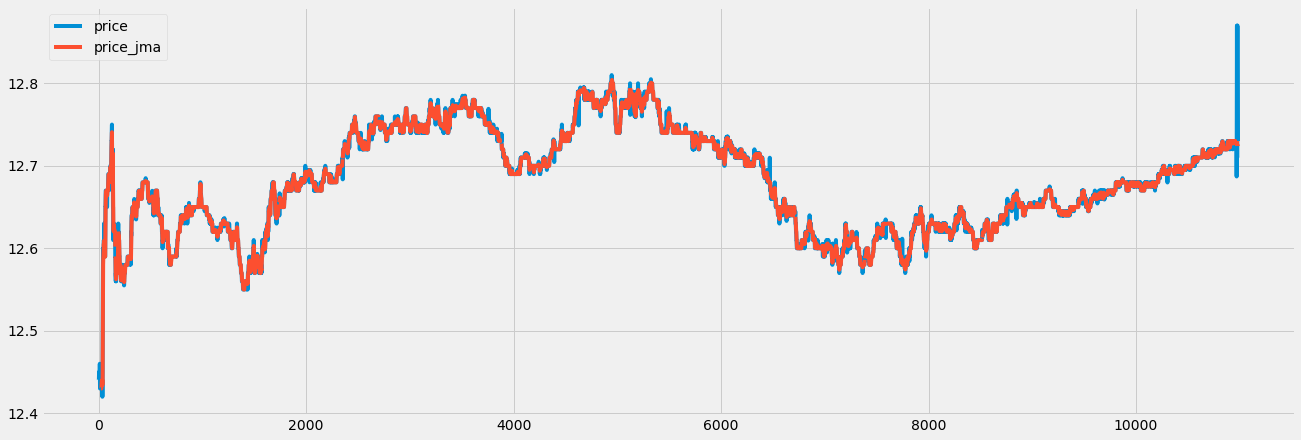

In [6]:
n = 0

# bar_dates[n]['ticks_df'][['price', 'price_jma']].plot_bokeh(sizing_mode="scale_height")
bar_dates[n]['ticks_df'][['price', 'price_jma']].plot()

<AxesSubplot:>

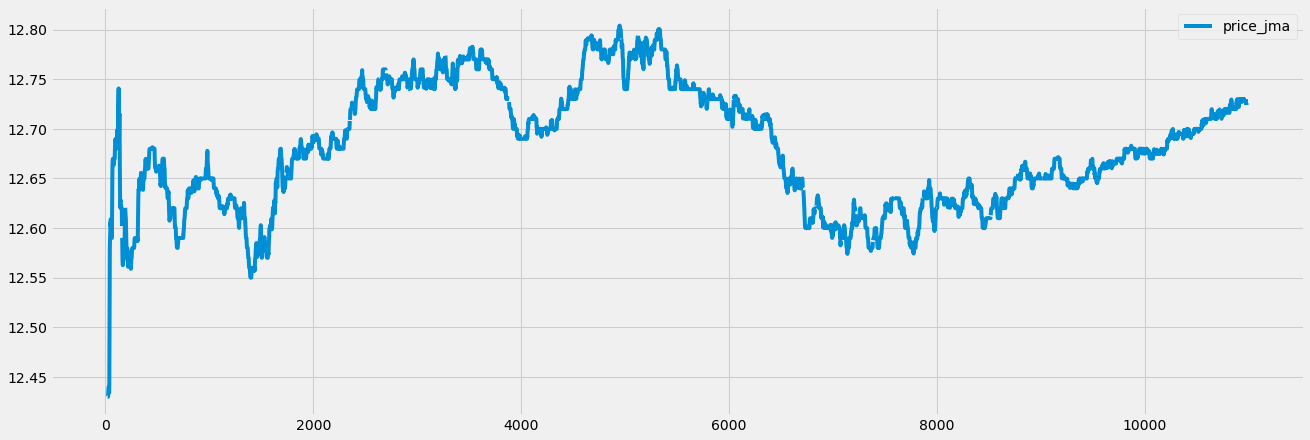

In [7]:
bar_dates[n]['ticks_df'][['price_jma']].plot()

In [8]:
bar_dates[n]['ticks_df'].status.value_counts() / len(bar_dates[n]['ticks_df'])

clean: market-open              0.978964
clean: pre-market               0.011565
filtered: irregular condition   0.005919
filtered: mad_warmup            0.001912
clean: after-hours              0.001093
filtered: mad_outlier           0.000455
filtered: ts diff               0.000091
Name: status, dtype: float64

<AxesSubplot:>

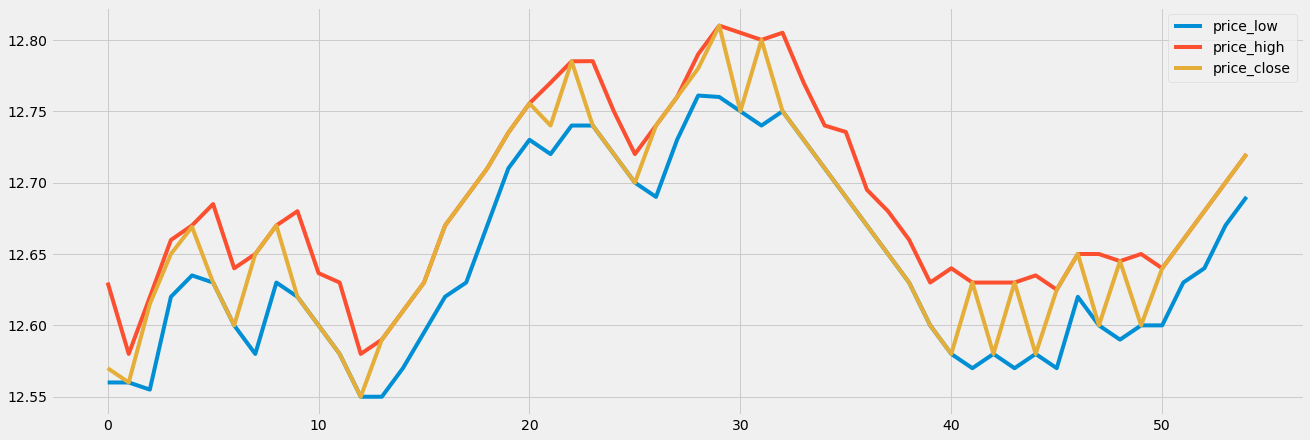

In [9]:
bar_dates[n]['bars_df'][['price_low', 'price_high', 'price_close']].plot()

In [ ]:
from sample_features import stacked
# fill daily gaps
stacked_df = stacked.fill_gaps_dates(bar_dates, fill_col='price_vwap')

stacked_df[['price_high','price_low','price_close', 'price_vwap']].plot_bokeh(sizing_mode="scale_height")

# stacked stats
stats_df = stacked.stacked_df_stats(stacked_df)

stats_df.describe()